In [110]:
# import packages:
import numpy as np                   # Numeric Python
import matplotlib.pyplot as plt      # Plotting routines
import h5py                          # general HDF5 reading/writing library
import rioxarray as rx               # Package to read raster data from hdf5 files
from pyproj import Transformer, CRS  # libraries to allow coordinate transforms
import glob                          # Package to locate files on disk
import os                            # File-level utilities
import re                            # regular expressions for string interpretation
import icepyx as ipx                 # Package to interact with ICESat-2 online resources
from sliderule import icesat2        # Package for online ICESat-2 processing
import geopandas                     # Package for reading in shapefiles
from shapely.geometry import Polygon # Package to create a polygon

In [2]:
%matplotlib widget

In [3]:
# logins, etc.

#HOST = 'https://urs.earthdata.nasa.gov'
#ipx.core.Earthdata.Earthdata('ben_smith','whatever@whatever.io', HOST).login()

url="icesat2sliderule.org"
icesat2.init(url, verbose=False)

In [168]:
# import shapefile
allan_hills3031 = geopandas.read_file('../data/allan_hills_main_blue_ice_area.shx')

# transform coordinates from epsg:3031 to epsg:4326
allan_hills = allan_hills3031.to_crs(4326)

# check if first and last coordinate are identical
print(list(allan_hills.geometry.iloc[0].exterior.coords)[0])
print(list(allan_hills.geometry.iloc[0].exterior.coords)[-1])

(159.29559020162503, -76.7539387618881)
(159.29559020162503, -76.7539387618881)


In [169]:
# create bounding box around shapefile
minx, miny, maxx, maxy = allan_hills3031.geometry.iloc[0].bounds
bounding_box = Polygon([(minx,miny),(maxx,miny),(maxx,maxy),(minx,maxy),(minx,miny)])
# assign crs to bounding box
bounding_box3031 = geopandas.GeoDataFrame({'name': ['bounding_box'], 'geometry': [bounding_box]}, crs="EPSG:3031")
# transform coordinates from epsg:3031 to epsg:4326
bounding_box4326 = bounding_box3031.to_crs(4326)


In [32]:
# Annika's bounding box:
# x,y
#-340,-80
#-480,-170

XR= np.array([-480, -340])*1.e3
YR= np.array([-170, -80])*1.e3

# shrink down to a tiny box in the center:
XR=np.mean(XR)+np.array([-5.e3, 5.e3])
YR=np.mean(YR)+np.array([-5.e3, 5.e3])


# Prepare coordinate transformations between lat/lon and polar stereographic
crs=CRS.from_epsg(3031)
to_xy_crs=Transformer.from_crs(crs.geodetic_crs, crs)
to_geo_crs=Transformer.from_crs(crs, crs.geodetic_crs)

corners_lat, corners_lon=to_geo_crs.transform(np.array(XR)[[0, 1, 1, 0, 0]], np.array(YR)[[0, 0, 1, 1, 0]])
latlims=[np.min(corners_lat), np.max(corners_lat)]
lonlims=[np.min(corners_lon), np.max(corners_lon)]

In [33]:
# run a slideRule ATL06 query.  Just ask for cycle 8 (Antarctic winter, 2020)
# to avoid getting swamped right away

# See parameters here:
# http://icesat2sliderule.org/rtd/user_guide/ICESat-2.html
params= { 'poly':[{'lon':this_lon, 'lat':this_lat} for this_lon, this_lat in zip(corners_lon, corners_lat)],
        'srt':3,
        'cnf':1,
        'len':10,
         'res':10,
         'ats':5,
         'cnt':10,
         'cycle':8,
         'maxi': 10,
        'pass_invalid':False}

D_IS_SR=icesat2.atl06p(params, 
                     asset="nsidc-s3")

In [177]:
# run a slideRule ATL06 query.  Just ask for cycle 8 (Antarctic winter, 2020) for bounding box around shapefile
# to avoid getting swamped right away

# See parameters here:
# http://icesat2sliderule.org/rtd/user_guide/ICESat-2.html
params= { 'poly':[{'lon':this_lon, 'lat':this_lat} for this_lon, this_lat in bounding_box4326.geometry.iloc[0].exterior.coords],
        'srt':3,
        'cnf':1,
        'len':10,
         'res':10,
         'ats':5,
         'cnt':10,
         'cycle':8,
         'maxi': 10,
        'pass_invalid':False}

D_IS_SR=icesat2.atl06p(params, 
                     asset="nsidc-s3")

In [178]:
D_IS_SR = D_IS_SR[(D_IS_SR.w_surface_window_final==3.)]
D_IS_SR

,cycle,distance,rgt,h_mean,rms_misfit,n_fit_photons,gt,dh_fit_dy,w_surface_window_final,spot,delta_time,h_sigma,dh_fit_dx,segment_id,pflags,geometry
time,,,,,,,,,,,,,,,,
2020-06-30 10:31:46.013873504,8,2.862341e+07,77,1790.964612,0.192995,103,50,0.0,3.0,1,7.874831e+07,0.019181,0.000771,1429892,0,POINT (159.44975 -76.59464)
2020-06-30 10:31:46.015277200,8,2.862342e+07,77,1790.956776,0.299902,105,50,0.0,3.0,1,7.874831e+07,0.029460,-0.000998,1429893,0,POINT (159.44969 -76.59472)
2020-06-30 10:31:46.016668176,8,2.862343e+07,77,1791.058233,0.181206,109,50,0.0,3.0,1,7.874831e+07,0.017444,0.018526,1429893,0,POINT (159.44962 -76.59481)
2020-06-30 10:31:46.018073808,8,2.862344e+07,77,1790.993707,0.329356,116,50,0.0,3.0,1,7.874831e+07,0.030864,0.004405,1429894,0,POINT (159.44956 -76.59490)
2020-06-30 10:31:46.019467200,8,2.862345e+07,77,1791.124515,0.322743,107,50,0.0,3.0,1,7.874831e+07,0.031546,0.018344,1429894,0,POINT (159.44950 -76.59499)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-03 20:34:09.954173776,8,3.159120e+07,1076,1902.303699,0.246340,24,60,0.0,3.0,2,8.440045e+07,0.052510,0.009335,1579059,0,POINT (159.04360 -76.58931)
2020-09-03 20:34:09.955591984,8,3.159121e+07,1076,1902.109833,0.188686,22,60,0.0,3.0,2,8.440045e+07,0.040378,0.017351,1579060,0,POINT (159.04353 -76.58922)
2020-09-03 20:34:09.956998656,8,3.159122e+07,1076,1902.060271,0.238401,14,60,0.0,3.0,2,8.440045e+07,0.068771,-0.002180,1579060,0,POINT (159.04347 -76.58913)


In [179]:
# transform coordinates
lon=np.array([gi.x for gi in D_IS_SR.geometry])
lat=np.array([gi.y for gi in D_IS_SR.geometry])
xy=to_xy_crs.transform(lat, lon)


<AxesSubplot:>

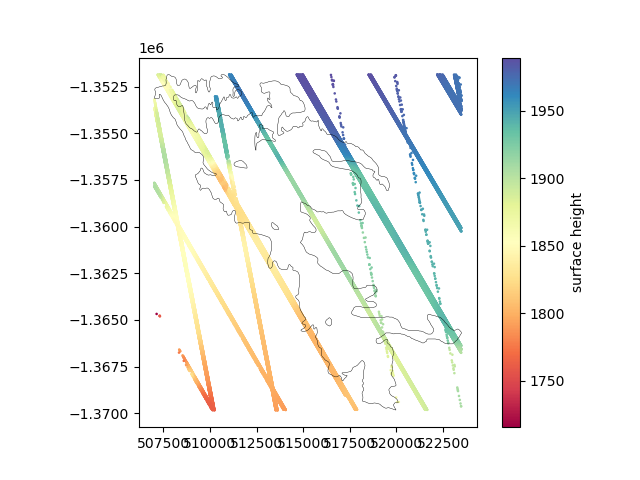

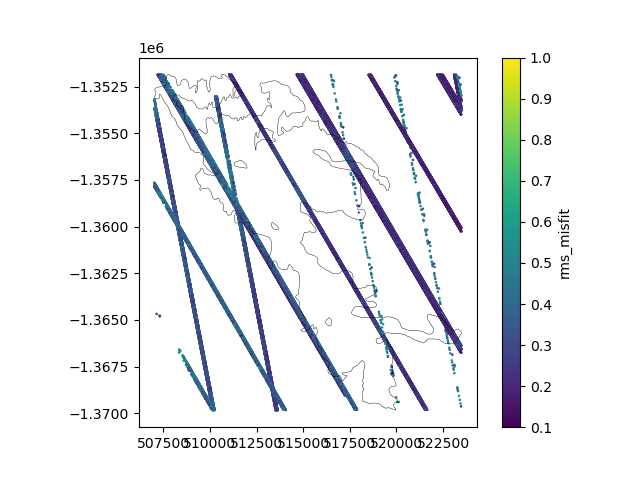

In [180]:
# plot data
fig, ax0 = plt.subplots(1,1); 
plt.scatter(xy[0], xy[1], c=D_IS_SR['h_mean'], cmap='Spectral', marker='o', s=0.7); plt.colorbar(label='surface height')
allan_hills3031.boundary.plot(ax=ax0,edgecolor='black',linewidth=0.3)

fig, ax1 = plt.subplots(1,1); 
plt.scatter(xy[0], xy[1], c=D_IS_SR['rms_misfit'], vmin=0.1, vmax=1, marker='o', s=0.7); plt.colorbar(label='rms_misfit'); 
allan_hills3031.boundary.plot(ax=ax1,edgecolor='black',linewidth=0.3)


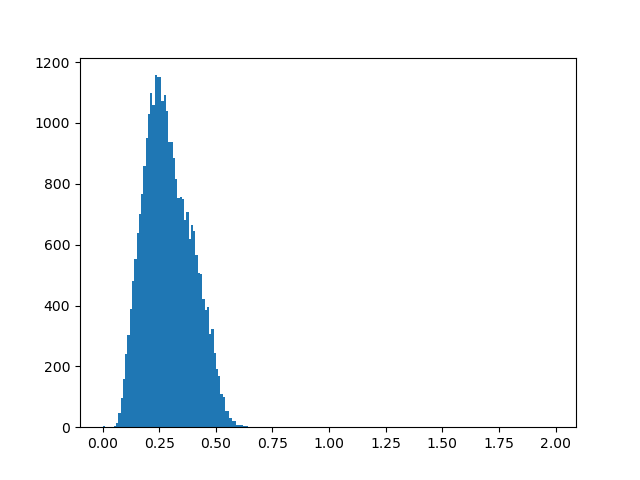

In [181]:
plt.figure(); plt.hist(D_IS_SR['rms_misfit'], np.arange(0, 2, 0.01));

In [182]:
sigma_extra=np.sqrt(np.maximum(0, D_IS_SR['rms_misfit']**2-(0.68e-9*1.5e8)**2))

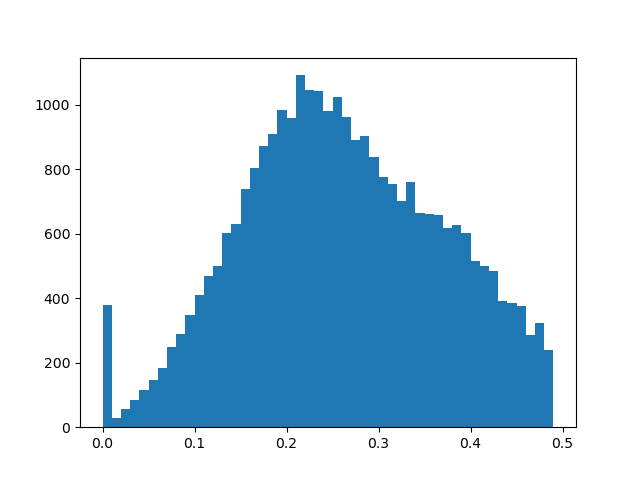

In [183]:
plt.figure(); plt.hist(sigma_extra, np.arange(0, .5, 0.01));

<AxesSubplot:>

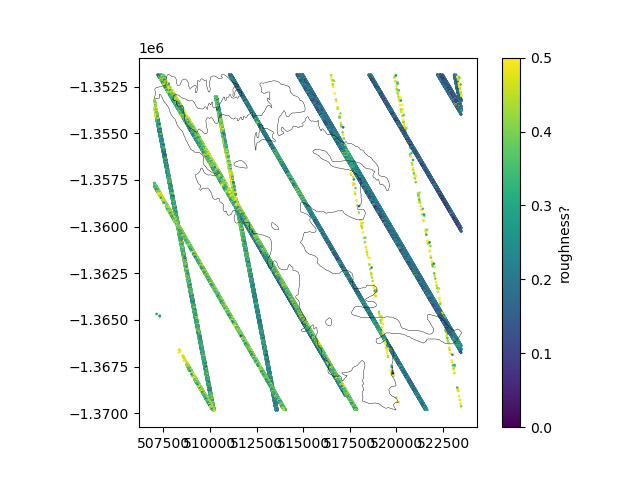

In [184]:
fig, ax2 = plt.subplots(1,1); 

plt.scatter(xy[0], xy[1], c=sigma_extra, vmin=0, vmax=0.5, marker='o', s=0.7); plt.colorbar(label='roughness?')
allan_hills3031.boundary.plot(ax=ax2,edgecolor='black',linewidth=0.3)

